# Lab 1 - A*

An implementation of the A* search algorithm ideated and programmed by **Claudio Savelli (s)** & **Mattia Sabato (s305849)** during a cold and rainy October. We have designed the algorithm in order to not only reach the goal in the **fastest way** but also in a **smart way**. We achieve this by **reducing the number of overlappings** and by forcing a solution which has the **smallest number of shared points** in the sets considered in the final solution. Even if slower, our solution shows better performances than the one proposed by the Professor when setting the number of overlappings as a major KPI.

## Set up

In [2]:
from random import random
from functools import reduce
from collections import namedtuple, deque
from queue import PriorityQueue, SimpleQueue
from time import time
from math import ceil
from tqdm.auto import tqdm
from random import seed

import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Define the configuration of the problem.
PROBLEM_SIZE = 27    # Number of points to be covered.
NUM_SETS = 100       # Number of sets in our pool.
ALPHA = 0.4          # Probability for a set to cover one point.

State = namedtuple('State', ['taken', 'not_taken'])

seed(42)
SETS = tuple(np.array([random() < ALPHA for _ in range(PROBLEM_SIZE)]) \
                for _ in range (NUM_SETS))

In [4]:
def goal_check(state: namedtuple) -> bool:
    '''
    Checks whether the problem is solvable and return `False` if not.
    '''
    return np.all(reduce(np.logical_or, [SETS[i] for i in state.taken], \
                         np.array([False for _ in range(PROBLEM_SIZE)])))


def proximity(state: namedtuple) -> int:
    '''
    Computes the proximity between a candidate state and the goal by
    summing the updated number of covered points.
    '''
    return sum(reduce(np.logical_or, [SETS[i] for i in state.taken],
               np.array([False for _ in range(PROBLEM_SIZE)])))


def cost(state: namedtuple) -> float:
    '''
    Computes the cost associated to a candidate state by summing the
    overlappings over the same point.
    '''
    if len(state.taken) == 0:
        return 0
    else:
        return sum(np.array([SETS[i] for i in state.taken]).sum(axis = 0))


def count_overlaps(state: namedtuple) -> int:
    '''
    Computes the total number of overlaps returned by the current state.
    '''
    return cost(state) - PROBLEM_SIZE


def visualize_state(state: namedtuple, title: str) -> None:
    '''
    Visualize how does the state look like. Thanks Beatrice Occhiena!
    [https://github.com/beatrice-occhiena](https://github.com/beatrice-occhiena)
    '''
    plt.figure(figsize = (7, 2))
    plt.imshow(take_state_from_set(state.taken), cmap = 'RdPu', aspect = 'auto')
    plt.title(title)
    plt.xlabel("Problem Elements")
    plt.xticks(np.arange(PROBLEM_SIZE))
    plt.ylabel("Taken Sets")
    
    # On the ticks of the y axis, show the indices of the taken sets
    plt.yticks(np.arange(len(state.taken)), list(state.taken))
    plt.show()


def covered(state: namedtuple) -> np.ndarray:
    '''
    Returns an array of `bool` specifying whether a point has
    been covered or not.
    '''
    return reduce(np.logical_or, [SETS[i] for i in state.taken],
                  np.array([False for _ in range(PROBLEM_SIZE)]))


def h_prof_c_prof(state: namedtuple, h: str = 'h3') -> int:
    '''
    Choose from a family of herustics. Possible choices make use 
    of the distance between the goal and the candidate set in different ways :
    - `h1`, considers the biggest set;
    - `h2`, considers the biggest set which has not been taken yet;
    - `h3`, considers also the order.

    Here the associated cost is simply the number of states taken.
    '''
    
    if h == 'h1':

        largest_set_size = max(sum(s) for s in SETS)
        missing_size = PROBLEM_SIZE - sum(covered(state))
        optimistic_estimate = ceil(missing_size / largest_set_size) 
        
        return len(state.taken) + optimistic_estimate
    
    elif h == 'h2':

        already_covered = covered(state)
        
        if np.all(already_covered):
            return 0
        
        largest_set_size = max(sum(np.logical_and(s, np.logical_not(already_covered))) for s in SETS)
        missing_size = PROBLEM_SIZE - sum(already_covered)
        optimistic_estimate = ceil(missing_size / largest_set_size)
        
        return len(state.taken) + optimistic_estimate
    
    elif h == 'h3':

        already_covered = covered(state)
    
        if np.all(already_covered):
            return 0
        
        missing_size = PROBLEM_SIZE - sum(already_covered)
        candidates = sorted((sum(np.logical_and(s, np.logical_not(already_covered))) for s in SETS),
                            reverse = True)
        taken = 1
        
        while sum(candidates[:taken]) < missing_size:
            taken += 1
        
        return len(state.taken) + taken
    

def take_state_from_set(state: set) -> list: 
    '''
    Takes as input the id of each state and returns a matrix where:
    - each row is a state;
    - each column is a point;
    - the value represent whether the point is covered by the set.

    Useful for visualization purposes.
    '''
    res = []
    for elem in state:
        res.append(SETS[elem])
    return res


def naive_distance(state: namedtuple) -> int:
    '''
    Simply returns the number of uncovered states.
    '''
    return PROBLEM_SIZE - sum(covered(state))
    

assert goal_check(State(set(range(NUM_SETS)), set())), 'Problem not solvable'

## Experiments: Us vs Prof

Here we test our algorithm using as a baseline the one provided by the Prof. Notice there is a **huge** difference in terms of **speed** and **number of iterations** between the two solutions, and this was actually expected since in the one proposed by us we are imposing stricter conditions. Still, given our goal, the solution is **more than satisfactory**! We actually were able to **minimize the overlappings** and reach the goal with a **small enough number of sets**. Given the premises and the requirements, it is a success! We have won, Prof

...or, at least, let us believe it.

P.S.: we would like to say **THANK YOU** to [Beatrice Occhiena](https://github.com/beatrice-occhiena), from which we have borrowed the function used to plot the sets. Good job!

0it [00:00, ?it/s]

7662it [00:54, 141.39it/s]


Solved in 7662 steps (3 tiles) in 54203ms
Sets: {88, 13, 46}
Overlaps: 4


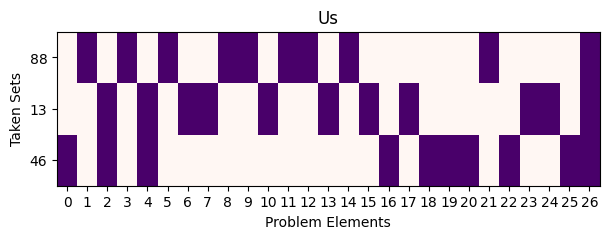

In [5]:
frontier = PriorityQueue() 
state = State(set(), set(range(NUM_SETS)))
frontier.put((proximity(state), state))

counter = 0
_, current_state = frontier.get()

tic = time()

with tqdm(total = None) as pbar:
    while not goal_check(current_state): 

        counter += 1

        for action in current_state.not_taken:

            new_state = State(current_state.taken ^ {action},
                              current_state.not_taken ^ {action})
            frontier.put((cost(new_state) - proximity(new_state), new_state))
        
        _, current_state = frontier.get()
        pbar.update(1)
    
toc = time()

print(f'Solved in {counter} steps ({len(current_state.taken)} tiles) \
in {(toc - tic)*1000:.0f}ms')
print(f'Sets: {current_state.taken}')
print(f'Overlaps: {count_overlaps(current_state)}')

visualize_state(current_state, 'Us')

9it [00:01,  7.53it/s]


Solved in 9 steps (3 tiles) in 1198ms
Sets: {82, 2, 58}
Overlaps: 13


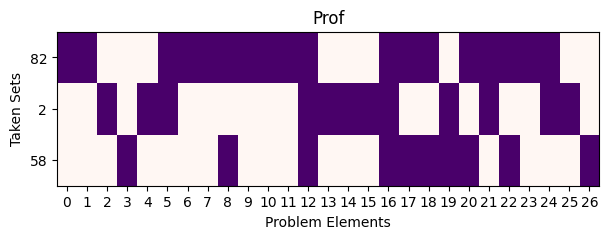

In [6]:
frontier = PriorityQueue() 
state = State(set(), set(range(NUM_SETS)))
frontier.put((h_prof_c_prof(state), state))

counter = 0
_, current_state_prof = frontier.get()

tic = time()

with tqdm(total = None) as pbar:
    while not goal_check(current_state_prof): 

        counter += 1

        for action in current_state_prof.not_taken:

            new_state = State(current_state_prof.taken ^ {action},
                              current_state_prof.not_taken ^ {action})
            frontier.put((h_prof_c_prof(new_state), new_state))
        
        _, current_state_prof = frontier.get()
        pbar.update(1)
    
toc = time()

print(f'Solved in {counter} steps ({len(current_state_prof.taken)} tiles) \
in {(toc - tic)*1000:.0f}ms')
print(f'Sets: {current_state_prof.taken}')
print(f'Overlaps: {count_overlaps(current_state_prof)}')

visualize_state(current_state_prof, 'Prof')

## Additional

Here we have analyzed also other search algorithms in order to show their performance in terms of overlappings. Our solution outperforms all of them, even though more slowly.

### Breadth-First

In [11]:
frontier = SimpleQueue()
state = State(set(), set(range(NUM_SETS)))
frontier.put(state)

counter = 0
current_state_bf = frontier.get()

tic = time()

with tqdm(total = None) as pbar:
    while not goal_check(current_state_bf):
        
        counter += 1
        
        for action in current_state_bf.not_taken:
            
            new_state = State(
                current_state_bf.taken ^ {action},
                current_state_bf.not_taken ^ {action})
            frontier.put(new_state)
        
        current_state_bf = frontier.get()
        pbar.update(1)

toc = time()

print(f'Solved in {counter} steps ({len(current_state_bf.taken)} tiles) \
in {(toc - tic)*1000:.0f}ms')
print(f'Sets: {current_state_bf.taken}')
print(f'Overlaps: {count_overlaps(current_state_bf)}')

visualize_state(current_state_bf, 'Breadth-First')

8277it [00:18, 724.61it/s]

### Additional: Depth-First

7it [00:00, 988.42it/s]

Solved in 7 steps (7 tiles) in 12ms
Sets: {96, 97, 98, 99, 93, 94, 95}
Overlaps: 51


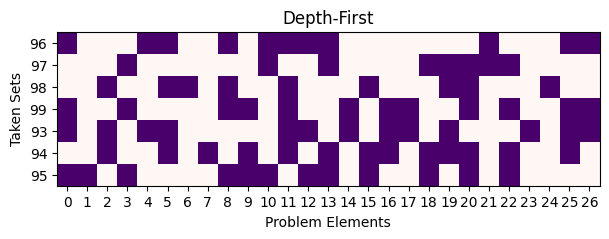

In [8]:
frontier = deque()
state = State(set(), set(range(NUM_SETS)))
frontier.append(state)

counter = 0
current_state_df = frontier.pop()

tic = time()

with tqdm(total = None) as pbar:
    while not goal_check(current_state_df):

        counter += 1
        
        for action in current_state_df[1]:
            
            new_state = State(current_state_df.taken ^ {action},
                              current_state_df.not_taken ^ {action})
            frontier.append(new_state)
            
        current_state_df = frontier.pop()
        pbar.update(1)

toc = time()

print(f'Solved in {counter} steps ({len(current_state_df.taken)} tiles) \
in {(toc - tic)*1000:.0f}ms')
print(f'Sets: {current_state_df.taken}')
print(f'Overlaps: {count_overlaps(current_state_df)}')

visualize_state(current_state_df, 'Depth-First')

### Additional: Greedy Best-First

3it [00:00, 299.96it/s]


Solved in 3 steps (3 tiles) in 14ms
Sets: {0, 2, 82}
Overlaps: 17


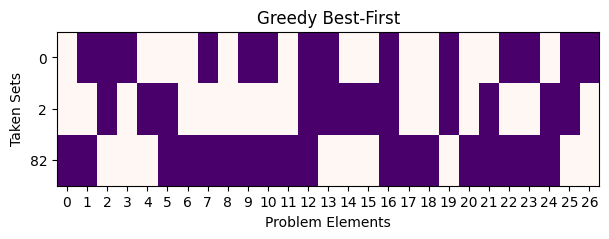

In [9]:
frontier = PriorityQueue()
state = State(set(), set(range(NUM_SETS)))
frontier.put((naive_distance(state), state))

counter = 0
_, current_state_gbf = frontier.get()

tic = time()

with tqdm(total = None) as pbar:
    while not goal_check(current_state_gbf):
        
        counter += 1
        
        for action in current_state_gbf[1]:
            
            new_state = State(
                current_state_gbf.taken ^ {action},
                current_state_gbf.not_taken ^ {action})
            frontier.put((naive_distance(new_state), new_state))
        
        _, current_state_gbf = frontier.get()
        pbar.update(1)

toc = time()

print(f'Solved in {counter} steps ({len(current_state_gbf.taken)} tiles) \
in {(toc - tic)*1000:.0f}ms')
print(f'Sets: {current_state_gbf.taken}')
print(f'Overlaps: {count_overlaps(current_state_gbf)}')

visualize_state(current_state_gbf, 'Greedy Best-First')